In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
import gym 
import os
import copy
from collections import deque

import matplotlib.pyplot as plt

In [90]:
class DQN() :
    
    def __init__(self , envName = "CartPole" ,version = "v0") :
        self.env = gym.make("{}-{}".format(envName,version))
        self.envName = envName
        self.prefix = "DQN"
        self.modelName = "{}-{}".format(self.prefix,self.envName)
        self.modelPath = "./model/{}-{}.h5".format(self.prefix,self.envName)
        self.historyPath = "./history/{}-{}.csv".format(self.prefix,self.envName)
        self.memory = deque(maxlen = 3000)
        
        self.gamma = 0.9
        
        #epsilon for egreedy
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self._buildModel()
        self.history = {"score":[]}
            
       
    def loadModel(self,path=None) :
        if path==None :
            path = self.modelPath
        assert os.path.exists(path) 
        self.model = tf.keras.models.load_model(path)
        self.epsilon = self.epsilon_min
        print("load model {} in {} success".format(self.modelName , path))
            
    def saveModel(self,path=None) :
        if path==None :
            path = self.modelPath
        self.model.save(path)
        print("save model {} success.".format(self.modelName ))
    def saveHistory(self,path = None) :
        if path==None :
            path = self.historyPath
        (pd.DataFrame(self.history)).to_csv(path)
        print("save history in {} success".format(path) )
    
    def loadHistory(self,path = None) :
        if path==None :
            path = self.historyPath
        assert os.path.exists(path)
        self.history["score"] = list( (pd.read_csv(path , usecols=["score"]))["score"] )
        print("load history in {} success".format(path) )
    
    def _buildModel(self) :
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(64 , input_shape = self.env.observation_space.shape ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(self.env.action_space.n ,activation="linear" ))
        model.compile(loss="mse", optimizer="adam" )
        model.summary()
        self.model = model
        print("build model {} success".format(self.modelName))
    
    def act(self,state):
        if np.random.random() <= self.epsilon :
            return self.env.action_space.sample()
        else :
            state = state.reshape(-1,self.env.observation_space.shape[0])
            return np.argmax(self.model.predict(state))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append( (state, action, reward, next_state, done) )
    
    def update_epsilon(self):
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self , batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            if not done :
                reward += self.gamma * np.amax(self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)
        self.update_epsilon()
    def PrepState(self , state ) :
        return state.reshape(-1,self.env.observation_space.shape[0])
    def getReward(state, reward, done , episode) :
        return 100 if done else reward
    
    def getScore(score,state, reward, done , episode) :
        return score+reward
    
    def train(self, epochs , render = False) :
        for epoch in range(epochs+1) :
            state  = self.env.reset()
            state = state.reshape(-1,self.env.observation_space.shape[0])
            done = False
            score = 0
            episode = 0
            while not done :
                episode += 1
                if render :
                    self.env.render()
                action = agent.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = next_state.reshape(-1,self.env.observation_space.shape[0])
                
                reward = self.getReward(state , reward , done , episode)
                score = self.getScore(score, state, reward, done, episode)
                
                agent.remember(state, action, reward, next_state, done)
                
                state = copy.deepcopy(next_state)
                state = state.reshape(-1,self.env.observation_space.shape[0])
                
                if done :
                    self.history["score"].append(score)
                    print("epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                    score=0
                    episode = 0
            self.replay(32)        
            if epoch%100 == 0 :
                self.saveModel()
        self.env.close()
    
    def play(self , epochs , render = False) :
        state  = self.env.reset()
        epoch = 0
        score = 0
        episode = 0
        while epoch<epochs :
            episode += 1
            if render :
                self.env.render()
            state = state.reshape(-1,self.env.observation_space.shape[0])
            action = np.argmax(self.model.predict(state))
            next_state , reward , done , _ = self.env.step(action)
            reward = self.getReward(state , reward , done , episode)
            score = self.getScore(score,state, reward, done , episode)
            state = copy.deepcopy(next_state)
            
            if done :
                print( "epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                epoch += 1
                state  = self.env.reset()
                score = 0
                episode = 0
        self.env.close()

In [91]:
class MountainCar(DQN) :
    def __init__(self) :
        
    def getReward(self,state, reward, done , episode) :
        #if done and episode<200 :
        #    print("=====================\nfinished the GAME!!!!\n=====================")
        #return state[0,0]+10 if  state[0,0]>=0.5 else state[0,0]+0.5
        return 100 if done and episode<200 else np.sin(3 * state[0,0])*.5
    def getScore(self,score,state, reward, done , episode) :
        height = np.sin(3 * state[0,0])*.5 + 0.5
        return max(score , height)
    
agent = MontainCar("MountainCar")
#agent.getReward = getReward
#agent.getScore = getScore
agent.loadModel()
agent.loadHistory()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_50 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 387       
Total params: 25,411
Trainable params: 25,411
Non-trainable params: 0
_________________________________________________________________
build model DQN-MountainCar success
load model DQN-MountainCar in ./model/DQN-MountainCar.h5 success
load history in ./history/test.csv success


In [121]:
agent.train(3000)

epoch 0 / 3000 played 0.996619697677 scores.
save model DQN-MountainCar success.
epoch 1 / 3000 played 0.00018032848687 scores.
epoch 2 / 3000 played 0.99490288348 scores.
epoch 3 / 3000 played 0.997850820905 scores.
epoch 4 / 3000 played 0.578917876584 scores.
epoch 5 / 3000 played 0.993557167889 scores.
epoch 6 / 3000 played 0.238484625298 scores.
epoch 7 / 3000 played 0.140224707452 scores.
epoch 8 / 3000 played 0.0897803005627 scores.
epoch 9 / 3000 played 0.0824094453376 scores.
epoch 10 / 3000 played 0.99818281572 scores.
epoch 11 / 3000 played 0.264209284664 scores.
epoch 12 / 3000 played 0.995220272219 scores.
epoch 13 / 3000 played 0.996277089561 scores.
epoch 14 / 3000 played 0.996972878672 scores.
epoch 15 / 3000 played 0.721260221647 scores.
epoch 16 / 3000 played 0.996972878672 scores.
epoch 17 / 3000 played 0.117045654978 scores.
epoch 18 / 3000 played 0.0998580457463 scores.
epoch 19 / 3000 played 0.989108321874 scores.
epoch 20 / 3000 played 0.105508437825 scores.
epoch

epoch 174 / 3000 played 0.119319434459 scores.
epoch 175 / 3000 played 0.0770704034395 scores.
epoch 176 / 3000 played 0.148844681539 scores.
epoch 177 / 3000 played 0.00471756159564 scores.
epoch 178 / 3000 played 0.166887539083 scores.
epoch 179 / 3000 played 0.0587843456387 scores.
epoch 180 / 3000 played 0.0722446688444 scores.
epoch 181 / 3000 played 0.267356046861 scores.
epoch 182 / 3000 played 0.209354491623 scores.
epoch 183 / 3000 played 0.147603170361 scores.
epoch 184 / 3000 played 0.281504145142 scores.
epoch 185 / 3000 played 0.209878802758 scores.
epoch 186 / 3000 played 0.156878491334 scores.
epoch 187 / 3000 played 0.0701505871218 scores.
epoch 188 / 3000 played 0.0144434846177 scores.
epoch 189 / 3000 played 0.00875182704309 scores.
epoch 190 / 3000 played 0.0872218889228 scores.
epoch 191 / 3000 played 0.159596874406 scores.
epoch 192 / 3000 played 0.133159648202 scores.
epoch 193 / 3000 played 0.0078844169868 scores.
epoch 194 / 3000 played 0.008981163425 scores.
ep

epoch 345 / 3000 played 0.996972878672 scores.
epoch 346 / 3000 played 0.135022859745 scores.
epoch 347 / 3000 played 0.0583939202647 scores.
epoch 348 / 3000 played 0.998691539248 scores.
epoch 349 / 3000 played 0.997959426943 scores.
epoch 350 / 3000 played 0.994716835119 scores.
epoch 351 / 3000 played 0.99723940491 scores.
epoch 352 / 3000 played 0.130194832621 scores.
epoch 353 / 3000 played 0.0907884146908 scores.
epoch 354 / 3000 played 0.13671815629 scores.
epoch 355 / 3000 played 0.996779235089 scores.
epoch 356 / 3000 played 0.259370010027 scores.
epoch 357 / 3000 played 0.907495083112 scores.
epoch 358 / 3000 played 0.312289788906 scores.
epoch 359 / 3000 played 0.996647593544 scores.
epoch 360 / 3000 played 0.998526949721 scores.
epoch 361 / 3000 played 0.0976279793947 scores.
epoch 362 / 3000 played 0.148981935773 scores.
epoch 363 / 3000 played 0.927421104681 scores.
epoch 364 / 3000 played 0.00551640639556 scores.
epoch 365 / 3000 played 0.00743446818444 scores.
epoch 36

epoch 517 / 3000 played 0.0620742532356 scores.
epoch 518 / 3000 played 0.21726433847 scores.
epoch 519 / 3000 played 0.143100967358 scores.
epoch 520 / 3000 played 0.00212536582048 scores.
epoch 521 / 3000 played 0.00277749532397 scores.
epoch 522 / 3000 played 0.997441098875 scores.
epoch 523 / 3000 played 0.893603898094 scores.
epoch 524 / 3000 played 0.997650595612 scores.
epoch 525 / 3000 played 0.0297878461046 scores.
epoch 526 / 3000 played 0.00051646875043 scores.
epoch 527 / 3000 played 0.00118452111163 scores.
epoch 528 / 3000 played 0.998209074503 scores.
epoch 529 / 3000 played 0.99549981236 scores.
epoch 530 / 3000 played 0.195801217088 scores.
epoch 531 / 3000 played 0.997443140885 scores.
epoch 532 / 3000 played 0.998608916384 scores.
epoch 533 / 3000 played 0.995220424213 scores.
epoch 534 / 3000 played 0.225724146833 scores.
epoch 535 / 3000 played 0.959243732068 scores.
epoch 536 / 3000 played 0.998547243159 scores.
epoch 537 / 3000 played 0.0151882793823 scores.
epoc

epoch 690 / 3000 played 0.995079581506 scores.
epoch 691 / 3000 played 0.0644433549215 scores.
epoch 692 / 3000 played 0.994867435238 scores.
epoch 693 / 3000 played 0.0622974947135 scores.
epoch 694 / 3000 played 0.20401932063 scores.
epoch 695 / 3000 played 0.172397961042 scores.
epoch 696 / 3000 played 0.0962122590415 scores.
epoch 697 / 3000 played 0.00216751151914 scores.
epoch 698 / 3000 played 0.467714111727 scores.
epoch 699 / 3000 played 0.0085930938721 scores.
epoch 700 / 3000 played 0.163247691155 scores.
save model DQN-MountainCar success.
epoch 701 / 3000 played 0.0834628606954 scores.
epoch 702 / 3000 played 0.994394405649 scores.
epoch 703 / 3000 played 0.995814243821 scores.
epoch 704 / 3000 played 0.000257919489104 scores.
epoch 705 / 3000 played 0.115093683532 scores.
epoch 706 / 3000 played 0.0846045498943 scores.
epoch 707 / 3000 played 0.994917294255 scores.
epoch 708 / 3000 played 0.995676136146 scores.
epoch 709 / 3000 played 0.992040520157 scores.
epoch 710 / 30

epoch 862 / 3000 played 0.992853948521 scores.
epoch 863 / 3000 played 0.995079581506 scores.
epoch 864 / 3000 played 0.346235861844 scores.
epoch 865 / 3000 played 0.0895072094467 scores.
epoch 866 / 3000 played 0.993437171799 scores.
epoch 867 / 3000 played 0.996972878672 scores.
epoch 868 / 3000 played 0.99776214145 scores.
epoch 869 / 3000 played 0.00450479746788 scores.
epoch 870 / 3000 played 0.000112910930741 scores.
epoch 871 / 3000 played 0.0644049215145 scores.
epoch 872 / 3000 played 0.993604915992 scores.
epoch 873 / 3000 played 0.992057722499 scores.
epoch 874 / 3000 played 0.229116908996 scores.
epoch 875 / 3000 played 0.997684133092 scores.
epoch 876 / 3000 played 0.0770149909079 scores.
epoch 877 / 3000 played 0.0596706501613 scores.
epoch 878 / 3000 played 0.997468165781 scores.
epoch 879 / 3000 played 0.99473542947 scores.
epoch 880 / 3000 played 0.00043339851416 scores.
epoch 881 / 3000 played 0.998159990955 scores.
epoch 882 / 3000 played 0.00291678535689 scores.
ep

epoch 1033 / 3000 played 0.997953238586 scores.
epoch 1034 / 3000 played 0.0139227022926 scores.
epoch 1035 / 3000 played 0.998400269122 scores.
epoch 1036 / 3000 played 0.997343413907 scores.
epoch 1037 / 3000 played 0.996387235719 scores.
epoch 1038 / 3000 played 0.997174614338 scores.
epoch 1039 / 3000 played 0.998490513284 scores.
epoch 1040 / 3000 played 0.998050760664 scores.
epoch 1041 / 3000 played 0.997114477692 scores.
epoch 1042 / 3000 played 0.126731734257 scores.
epoch 1043 / 3000 played 0.190844824354 scores.
epoch 1044 / 3000 played 0.994763586326 scores.
epoch 1045 / 3000 played 0.996886308311 scores.
epoch 1046 / 3000 played 0.996972878672 scores.
epoch 1047 / 3000 played 0.996972878672 scores.
epoch 1048 / 3000 played 0.0150504413567 scores.
epoch 1049 / 3000 played 0.0152522803972 scores.
epoch 1050 / 3000 played 1.02548381549e-05 scores.
epoch 1051 / 3000 played 0.00573335072109 scores.
epoch 1052 / 3000 played 0.996136713666 scores.
epoch 1053 / 3000 played 0.99617

epoch 1203 / 3000 played 0.994763586326 scores.
epoch 1204 / 3000 played 0.996174941722 scores.
epoch 1205 / 3000 played 0.721260221647 scores.
epoch 1206 / 3000 played 0.998170050543 scores.
epoch 1207 / 3000 played 0.996952688328 scores.
epoch 1208 / 3000 played 0.107717193834 scores.
epoch 1209 / 3000 played 0.141717251708 scores.
epoch 1210 / 3000 played 0.154657117921 scores.
epoch 1211 / 3000 played 0.11551582658 scores.
epoch 1212 / 3000 played 0.193654473051 scores.
epoch 1213 / 3000 played 0.164850570481 scores.
epoch 1214 / 3000 played 0.000347741079608 scores.
epoch 1215 / 3000 played 0.0911063579129 scores.
epoch 1216 / 3000 played 0.998133829791 scores.
epoch 1217 / 3000 played 0.996972878672 scores.
epoch 1218 / 3000 played 0.915495970249 scores.
epoch 1219 / 3000 played 0.998055356594 scores.
epoch 1220 / 3000 played 0.996972878672 scores.
epoch 1221 / 3000 played 0.997025727027 scores.
epoch 1222 / 3000 played 0.0736665181278 scores.
epoch 1223 / 3000 played 0.996972878

epoch 1372 / 3000 played 0.080352335583 scores.
epoch 1373 / 3000 played 0.996720355834 scores.
epoch 1374 / 3000 played 0.163905621088 scores.
epoch 1375 / 3000 played 0.103527867685 scores.
epoch 1376 / 3000 played 0.992247968114 scores.
epoch 1377 / 3000 played 0.994763586326 scores.
epoch 1378 / 3000 played 0.995374634896 scores.
epoch 1379 / 3000 played 0.996438590431 scores.
epoch 1380 / 3000 played 0.992976889081 scores.
epoch 1381 / 3000 played 0.00420208468667 scores.
epoch 1382 / 3000 played 0.945660241208 scores.
epoch 1383 / 3000 played 0.996174941722 scores.
epoch 1384 / 3000 played 0.997961606344 scores.
epoch 1385 / 3000 played 0.991967936632 scores.
epoch 1386 / 3000 played 0.995583474397 scores.
epoch 1387 / 3000 played 0.993691471928 scores.
epoch 1388 / 3000 played 0.998681236619 scores.
epoch 1389 / 3000 played 0.995955838744 scores.
epoch 1390 / 3000 played 0.993910193584 scores.
epoch 1391 / 3000 played 0.996141313836 scores.
epoch 1392 / 3000 played 0.05362596498

epoch 1542 / 3000 played 0.993626725112 scores.
epoch 1543 / 3000 played 0.996282396571 scores.
epoch 1544 / 3000 played 0.993626725112 scores.
epoch 1545 / 3000 played 0.988577643639 scores.
epoch 1546 / 3000 played 0.0876041942714 scores.
epoch 1547 / 3000 played 0.991967936632 scores.
epoch 1548 / 3000 played 0.997448960872 scores.
epoch 1549 / 3000 played 0.99827867001 scores.
epoch 1550 / 3000 played 0.991967936632 scores.
epoch 1551 / 3000 played 0.997809815083 scores.
epoch 1552 / 3000 played 0.997393131145 scores.
epoch 1553 / 3000 played 0.994133667447 scores.
epoch 1554 / 3000 played 0.990286723634 scores.
epoch 1555 / 3000 played 0.0739997856753 scores.
epoch 1556 / 3000 played 0.0544309158375 scores.
epoch 1557 / 3000 played 0.997243831064 scores.
epoch 1558 / 3000 played 0.996974623094 scores.
epoch 1559 / 3000 played 0.997489388515 scores.
epoch 1560 / 3000 played 0.0655777646631 scores.
epoch 1561 / 3000 played 0.998050760664 scores.
epoch 1562 / 3000 played 0.0531863680

epoch 1711 / 3000 played 0.995650969473 scores.
epoch 1712 / 3000 played 0.996174941722 scores.
epoch 1713 / 3000 played 0.996174941722 scores.
epoch 1714 / 3000 played 0.997718619995 scores.
epoch 1715 / 3000 played 0.997508134549 scores.
epoch 1716 / 3000 played 0.996872563706 scores.
epoch 1717 / 3000 played 0.996379965925 scores.
epoch 1718 / 3000 played 0.99715220037 scores.
epoch 1719 / 3000 played 0.996855778195 scores.
epoch 1720 / 3000 played 0.99715220037 scores.
epoch 1721 / 3000 played 0.998666716811 scores.
epoch 1722 / 3000 played 0.0529974751326 scores.
epoch 1723 / 3000 played 0.996972878672 scores.
epoch 1724 / 3000 played 0.0601244234073 scores.
epoch 1725 / 3000 played 0.989895188547 scores.
epoch 1726 / 3000 played 0.997807322938 scores.
epoch 1727 / 3000 played 0.993001027432 scores.
epoch 1728 / 3000 played 0.99432243907 scores.
epoch 1729 / 3000 played 0.992408690505 scores.
epoch 1730 / 3000 played 0.0122247410951 scores.
epoch 1731 / 3000 played 0.056078439137 

epoch 1880 / 3000 played 0.066198097405 scores.
epoch 1881 / 3000 played 0.108548645788 scores.
epoch 1882 / 3000 played 0.994198815938 scores.
epoch 1883 / 3000 played 0.996307540666 scores.
epoch 1884 / 3000 played 0.0844622378463 scores.
epoch 1885 / 3000 played 0.993864555443 scores.
epoch 1886 / 3000 played 0.998454802811 scores.
epoch 1887 / 3000 played 0.184679352157 scores.
epoch 1888 / 3000 played 0.997615971152 scores.
epoch 1889 / 3000 played 0.126090993391 scores.
epoch 1890 / 3000 played 0.998464227727 scores.
epoch 1891 / 3000 played 0.296046676462 scores.
epoch 1892 / 3000 played 0.996972878672 scores.
epoch 1893 / 3000 played 0.994276293886 scores.
epoch 1894 / 3000 played 0.996972878672 scores.
epoch 1895 / 3000 played 0.997388317734 scores.
epoch 1896 / 3000 played 0.995045917581 scores.
epoch 1897 / 3000 played 0.222708762841 scores.
epoch 1898 / 3000 played 0.129334231189 scores.
epoch 1899 / 3000 played 0.996105853407 scores.
epoch 1900 / 3000 played 0.998690968835

epoch 2049 / 3000 played 0.997513824063 scores.
epoch 2050 / 3000 played 0.127008059284 scores.
epoch 2051 / 3000 played 0.174644690334 scores.
epoch 2052 / 3000 played 0.0383720363605 scores.
epoch 2053 / 3000 played 0.997372990133 scores.
epoch 2054 / 3000 played 0.998341645468 scores.
epoch 2055 / 3000 played 0.919063624508 scores.
epoch 2056 / 3000 played 0.996913830284 scores.
epoch 2057 / 3000 played 0.056300334157 scores.
epoch 2058 / 3000 played 0.997513824063 scores.
epoch 2059 / 3000 played 0.044101680847 scores.
epoch 2060 / 3000 played 0.000439212253953 scores.
epoch 2061 / 3000 played 0.0595238723558 scores.
epoch 2062 / 3000 played 0.000104809235821 scores.
epoch 2063 / 3000 played 0.997149548085 scores.
epoch 2064 / 3000 played 0.996990097211 scores.
epoch 2065 / 3000 played 0.0824604912788 scores.
epoch 2066 / 3000 played 0.99794407608 scores.
epoch 2067 / 3000 played 0.101164342706 scores.
epoch 2068 / 3000 played 0.99561763964 scores.
epoch 2069 / 3000 played 0.996514

epoch 2218 / 3000 played 0.137280527573 scores.
epoch 2219 / 3000 played 0.996878954413 scores.
epoch 2220 / 3000 played 0.997557627554 scores.
epoch 2221 / 3000 played 0.997557627554 scores.
epoch 2222 / 3000 played 0.996870255149 scores.
epoch 2223 / 3000 played 0.997557627554 scores.
epoch 2224 / 3000 played 0.996167615379 scores.
epoch 2225 / 3000 played 0.997023161425 scores.
epoch 2226 / 3000 played 0.998241594936 scores.
epoch 2227 / 3000 played 0.192735620012 scores.
epoch 2228 / 3000 played 0.721260221647 scores.
epoch 2229 / 3000 played 0.74108447504 scores.
epoch 2230 / 3000 played 0.996590660542 scores.
epoch 2231 / 3000 played 0.995670399992 scores.
epoch 2232 / 3000 played 0.995670399992 scores.
epoch 2233 / 3000 played 0.0193856975284 scores.
epoch 2234 / 3000 played 0.0307800790682 scores.
epoch 2235 / 3000 played 0.0269348369684 scores.
epoch 2236 / 3000 played 0.0517688761547 scores.
epoch 2237 / 3000 played 0.194761847591 scores.
epoch 2238 / 3000 played 0.0795248620

epoch 2388 / 3000 played 0.998611204261 scores.
epoch 2389 / 3000 played 0.996896080455 scores.
epoch 2390 / 3000 played 0.997003580503 scores.
epoch 2391 / 3000 played 0.995401569636 scores.
epoch 2392 / 3000 played 0.994359368492 scores.
epoch 2393 / 3000 played 0.992220843467 scores.
epoch 2394 / 3000 played 0.992038578276 scores.
epoch 2395 / 3000 played 0.996346882761 scores.
epoch 2396 / 3000 played 0.997919867377 scores.
epoch 2397 / 3000 played 0.994719206144 scores.
epoch 2398 / 3000 played 0.935440956269 scores.
epoch 2399 / 3000 played 0.995027990104 scores.
epoch 2400 / 3000 played 0.0033604265444 scores.
save model DQN-MountainCar success.
epoch 2401 / 3000 played 0.994428438986 scores.
epoch 2402 / 3000 played 0.828973127789 scores.
epoch 2403 / 3000 played 0.996805834713 scores.
epoch 2404 / 3000 played 0.997644662334 scores.
epoch 2405 / 3000 played 0.998418948371 scores.
epoch 2406 / 3000 played 0.994092346615 scores.
epoch 2407 / 3000 played 0.998333698983 scores.
epo

epoch 2557 / 3000 played 0.990988636643 scores.
epoch 2558 / 3000 played 0.301889448629 scores.
epoch 2559 / 3000 played 0.0723889096221 scores.
epoch 2560 / 3000 played 0.997030065365 scores.
epoch 2561 / 3000 played 0.00560077554337 scores.
epoch 2562 / 3000 played 7.39940098776e-06 scores.
epoch 2563 / 3000 played 0.997224132547 scores.
epoch 2564 / 3000 played 0.99825358768 scores.
epoch 2565 / 3000 played 0.997337415454 scores.
epoch 2566 / 3000 played 0.996416172918 scores.
epoch 2567 / 3000 played 0.0840789809642 scores.
epoch 2568 / 3000 played 0.995490281344 scores.
epoch 2569 / 3000 played 0.99719102271 scores.
epoch 2570 / 3000 played 0.990271413095 scores.
epoch 2571 / 3000 played 0.994172649173 scores.
epoch 2572 / 3000 played 0.0846568930971 scores.
epoch 2573 / 3000 played 0.994931013151 scores.
epoch 2574 / 3000 played 0.997026830446 scores.
epoch 2575 / 3000 played 0.990277447187 scores.
epoch 2576 / 3000 played 0.139542247421 scores.
epoch 2577 / 3000 played 0.9959008

epoch 2726 / 3000 played 0.156217318715 scores.
epoch 2727 / 3000 played 0.195917153108 scores.
epoch 2728 / 3000 played 0.99821553456 scores.
epoch 2729 / 3000 played 0.998447468399 scores.
epoch 2730 / 3000 played 0.131237736792 scores.
epoch 2731 / 3000 played 0.176300962851 scores.
epoch 2732 / 3000 played 0.996972878672 scores.
epoch 2733 / 3000 played 0.158077429085 scores.
epoch 2734 / 3000 played 0.0720888431178 scores.
epoch 2735 / 3000 played 0.990023477251 scores.
epoch 2736 / 3000 played 0.0481901112927 scores.
epoch 2737 / 3000 played 0.162735150964 scores.
epoch 2738 / 3000 played 0.125651506138 scores.
epoch 2739 / 3000 played 0.044409703449 scores.
epoch 2740 / 3000 played 0.00256324113093 scores.
epoch 2741 / 3000 played 0.996972878672 scores.
epoch 2742 / 3000 played 0.997353662722 scores.
epoch 2743 / 3000 played 0.0546286777671 scores.
epoch 2744 / 3000 played 0.0360600423529 scores.
epoch 2745 / 3000 played 0.0534242458045 scores.
epoch 2746 / 3000 played 0.9985176

epoch 2895 / 3000 played 0.996045588204 scores.
epoch 2896 / 3000 played 0.994535488369 scores.
epoch 2897 / 3000 played 0.996972878672 scores.
epoch 2898 / 3000 played 0.996972878672 scores.
epoch 2899 / 3000 played 0.00950674289799 scores.
epoch 2900 / 3000 played 0.000503917510173 scores.
save model DQN-MountainCar success.
epoch 2901 / 3000 played 0.997815549446 scores.
epoch 2902 / 3000 played 0.996972878672 scores.
epoch 2903 / 3000 played 0.00618099520965 scores.
epoch 2904 / 3000 played 0.00537726584721 scores.
epoch 2905 / 3000 played 0.00057233096765 scores.
epoch 2906 / 3000 played 0.0100458402665 scores.
epoch 2907 / 3000 played 0.0103030828937 scores.
epoch 2908 / 3000 played 0.0109042197969 scores.
epoch 2909 / 3000 played 1.35455526857e-05 scores.
epoch 2910 / 3000 played 0.996972878672 scores.
epoch 2911 / 3000 played 0.996445741657 scores.
epoch 2912 / 3000 played 0.996972878672 scores.
epoch 2913 / 3000 played 0.998144353076 scores.
epoch 2914 / 3000 played 0.99697287

In [123]:
agent.play(5,True)

epoch 0 / 5 played 0.998736793448 scores.
epoch 1 / 5 played 0.996696043659 scores.
epoch 2 / 5 played 0.996972878672 scores.
epoch 3 / 5 played 0.997097378468 scores.
epoch 4 / 5 played 0.995878828006 scores.


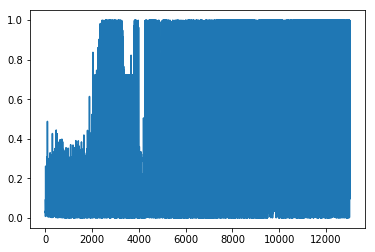

In [122]:
plt.plot(agent.history["score"] )

(array([237., 101.,  32.,  17.,   7.,   5.,   8.,  20.,  17., 556.]),
 array([2.09957452e-06, 9.98763184e-02, 1.99750537e-01, 2.99624756e-01,
        3.99498975e-01, 4.99373194e-01, 5.99247412e-01, 6.99121631e-01,
        7.98995850e-01, 8.98870069e-01, 9.98744287e-01]),
 <a list of 10 Patch objects>)

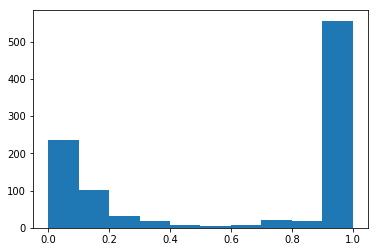

In [120]:
plt.hist(agent.history["score"][-1000:] ) #, cumulative=True)

In [29]:
#for accident shut down
agent.env.close()

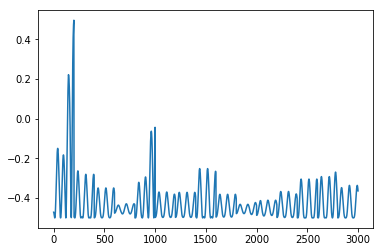

In [88]:
## show memory
height = []
for i in range(len(agent.memory)) :
    state, action, reward, next_state, done = agent.memory[i]
    height.append(np.sin(3 * state[0,0])*.5 )
plt.plot(height)

In [110]:
agent.saveHistory()

save history in ./history/DQN-MountainCar.csv success
